## **Lab Activity #3: An Agent-based Model of Boids**


Submitted by:\
IMPERIAL, Austin Gomez\
MANINANG, Enika Aubrey\
VILLADAREZ, Luis Gabriel\
YAPAN, Miguel Carlo

Date: 03--22

##**Problem 1**



To add interactivity for the users, sliders was implemented for each of the weights: `w_avoid`, `w_center`, `w_align`, and `w_love`. The `scene` object has a `caption` attribute and an `append_to_caption()` method to display texts below the simulation. The sliders were made using the `slider()` function available in `vpython` with min values of 0 and max values of 10. Each slider also requires a function to be called whenever the value of the slider is changed. These functions, that are binded to the sliders, changes the `wtext` beside the slider for it to display the current value of the slider.

Then, the `set_goal()` function was edited to set each of the value of the slider to the weights for the rules. This is done by using the `value` attribute of the corresponding slider.

##**Problem 2**

A new rule, `lateral` was made to make the boids move laterally when there are boids in their line of sight. To determine if there are any boids in the self's line of sight, we made use of the `get_neighbors` method. The radius and angle input for the self's line of sight could be modified using a slider. The maximum angle is `(np.pi)/2` while the maximum radius is `1`.

If there are no boids in the line of sight, we ignore the rule, while if there are boids in the line of sight, we take the vector from the `self` towards the mean of the boids in the line of sight. We do this using the `vector_toward_center` method. 

In order to move laterally, the `self` either goes to the direction of the cross product of the vector `self.pos` and the vector towards the center of the boids in front. That is, the `self` could swerve to the direction of `cross(self.pos, front_vector)` or `cross(front_vector, self.pos)`. 

Finally, to determine which direction the `self` will move to, we calculate the angle between `self.vel` and the cross product mentioned before. If the angle is less than `(np.pi)/2`, then the `self` will move towards that direction. If the angle is not less than `(np.pi)/2`, then it will move to the opposite direction. If the velocity is too far from each vector, then we will pick a random cross product to move towards to.

In our test, we noticed that the birds demonstrate a wave-like behavior when the sliders are set to 0, 10, 0, 0, 10, 0.5, and 0.3 for Avoid, Center, Align, Love, Lateral, Radius, and Angle sliders, respectively. This indicates that the boids will move laterally away if there are boids in front of them, but will not stay too far from the group. This is to be expected, since both Center and Lateral are set to 10. If the angle slider is set to 0, this indicates that the boids will only move if their axis is parallel to another boid's axis. No noticeable effects to the boid's behavior was shown, as the group assumes that it has to be perfectly parallel and it is harder to replicate in a 3d space.  

Overall, the lateral rule that we have set works by determining two paths that a boid could take generated from two cross products. 

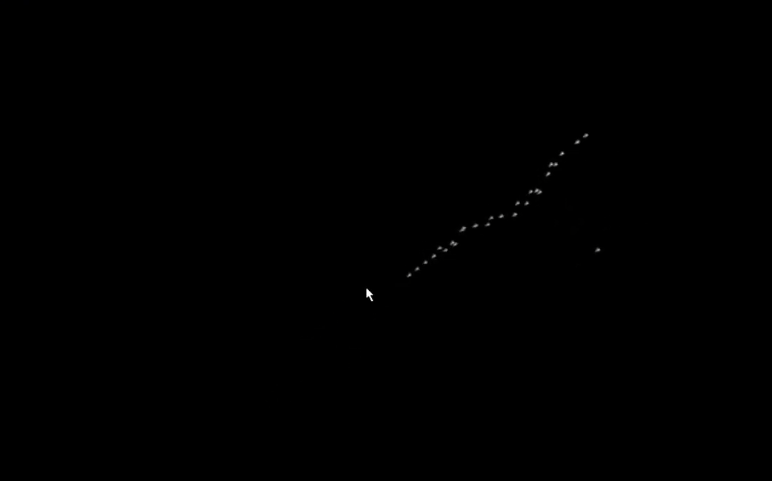

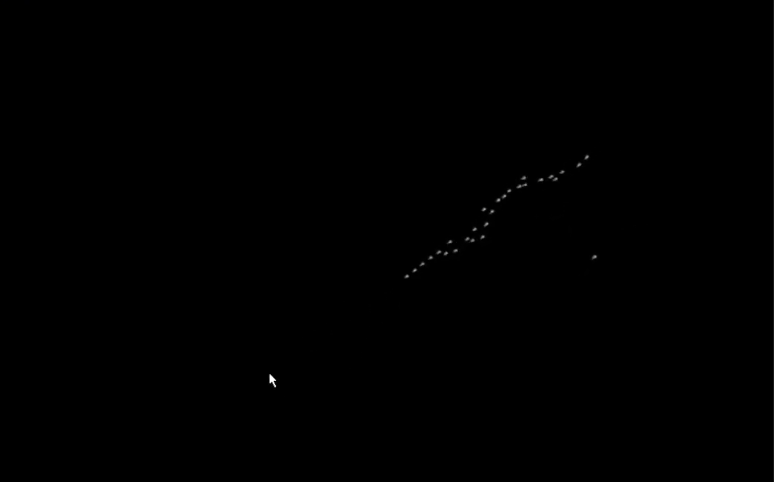

In [ ]:
#take the mean of vectors of the boids in the line of sight
#take cross product of vector difference of mean vector and self.pos
#input option 1 and option 2

""" Code example from Think Complexity, by Allen Downey.
Original code by Matt Aasted, modified by Allen Downey.
Based on Reynolds, "Flocks, Herds and Schools" and
Flake, "The Computational Beauty of Nature."
Copyright 2011 Allen B. Downey.
Distributed under the MIT License.
"""
try:
    from vpython import *
except:
    print("This program requires VPython 7, which you can read about")
    print("at http://vpython.org/.  If you are using Anaconda, you can")
    print("install VPython by running the following on the command line:")
    print("conda install -c vpython vpython")
    import sys
    sys.exit()

import numpy as np
import random as rand

null_vector = vector(0,0,0)


def random_vector(a, b):
    """Create a vector with each element uniformly distributed in [a, b)."""
    coords = np.random.uniform(a, b, size=3)
    return vector(*coords)


def limit_vector(vect):
    """If the magnitude is greater than 1, set it to 1"""
    if vect.mag > 1:
        vect.mag = 1
    return vect


class Boid(cone):
    """A Boid is a VPython cone with a velocity and an axis."""

    def __init__(self, radius=0.03, length=0.1):
        pos = random_vector(0, 1)
        self.vel = random_vector(0, 1).norm()
        cone.__init__(self, pos=pos, radius=radius, length=length)
        self.axis = length * self.vel

    def get_neighbors(self, boids, radius, angle):
        """Return a list of neighbors within a field of view.
        boids: list of boids
        radius: field of view radius
        angle: field of view angle in radians
        returns: list of Boid
        """
        neighbors = []
        for boid in boids:
            if boid is self:
                continue
            offset = boid.pos - self.pos

            # if not in range, skip it
            if offset.mag > radius:
                continue

            # if not within viewing angle, skip it
            diff = self.vel.diff_angle(offset)
            if abs(diff) > angle:
                continue

            # otherwise add it to the list
            neighbors.append(boid)

        return neighbors

    def center(self, boids, radius=1, angle=1):
        """Find the center of mass of other boids in range and
        return a vector pointing toward it."""
        neighbors = self.get_neighbors(boids, radius, angle)
        vecs = [boid.pos for boid in neighbors]
        return self.vector_toward_center(vecs)

    def vector_toward_center(self, vecs):
        """Vector from self to the mean of vecs.
        vecs: sequence of vector
        returns: Vector
        """
        if vecs:
            center = np.mean(vecs)
            toward = vector(center - self.pos)
            return limit_vector(toward)
        else:
            return null_vector

    def avoid(self, boids, carrot, radius=0.3, angle=np.pi):
        """Find the center of mass of all objects in range and
        return a vector in the opposite direction, with magnitude
        proportional to the inverse of the distance (up to a limit)."""
        objects = boids + [carrot]
        neighbors = self.get_neighbors(objects, radius, angle)
        vecs = [boid.pos for boid in neighbors]
        return -self.vector_toward_center(vecs)

    def align(self, boids, radius=0.5, angle=1):
        """Return the average heading of other boids in range.
        boids: list of Boids
        """
        neighbors = self.get_neighbors(boids, radius, angle)
        vecs = [boid.vel for boid in neighbors]
        return self.vector_toward_center(vecs)

    def love(self, carrot):
        """Returns a vector pointing toward the carrot."""
        toward = carrot.pos - self.pos
        return limit_vector(toward)
    
    def lateral(self, boids, radius, angle):
        """When a boid sees an object within 0.3 units of their line of sight, they move laterally. 
        In order to do this, we rotate the vector that points from the current boid to the boid in front by pi/2"""
        line_of_sight = self.get_neighbors(boids, radius, angle)
        if len(line_of_sight) == 0:
            return null_vector
        else: 
            front_boids_vectors = [boid.pos for boid in line_of_sight]
            front_vector = self.vector_toward_center(front_boids_vectors)
            toward_1 = cross(self.pos, front_vector)
            toward_2 = cross(front_vector, self.pos)
            diff1 = abs(self.vel.diff_angle(toward_1))
            diff2 = abs(self.vel.diff_angle(toward_2))
            if diff1 < (np.pi/2):
                return limit_vector(toward_1)
            elif diff2 < (np.pi/2):
                return limit_vector(toward_2)
            else:
                return rand.choice([limit_vector(toward_1),limit_vector(toward_2)])

    def set_goal(self, boids, carrot):  
        """Sets the goal to be the weighted sum of the goal vectors."""

        # weights for various rules
        w_avoid = avoid_slider.value
        w_center = center_slider.value
        w_align = align_slider.value
        w_love = love_slider.value
        w_lateral = lateral_slider.value

        self.goal = (w_center * self.center(boids) +
                     w_avoid * self.avoid(boids, carrot) +
                     w_align * self.align(boids) +
                     w_love * self.love(carrot) + 
                     w_lateral * self.lateral(boids, radius = los_radius_slider.value, angle = los_angle_slider.value))
        self.goal.mag = 1

    def move(self, mu=0.1, dt=0.1):
        """Update the velocity, position and axis vectors.
        mu: how fast the boids can turn (maneuverability).
        dt: time step
        """
        self.vel = (1-mu) * self.vel + mu * self.goal
        self.vel.mag = 1
        self.pos += dt * self.vel
        self.axis = self.length * self.vel


class World(object):

    def __init__(self, n=10):
        """Create n Boids and one carrot.
        tracking: indicates whether the carrot follows the mouse
        """
        self.boids = [Boid() for i in range(n)]
        self.carrot = sphere(pos=vector(1,0,0),
                             radius=0.1,
                             color=vector(1,0,0))
        self.tracking = False

    def step(self):
        """Compute one time step."""
        # move the boids
        for boid in self.boids:
            boid.set_goal(self.boids, self.carrot)
            boid.move()

        # if we're tracking, move the carrot
        if self.tracking:
            self.carrot.pos = scene.mouse.pos


n = 30
size = 5

world = World(n)
scene.center = world.carrot.pos
scene.autoscale = False

def toggle_tracking(evt):
    """If we're currently tracking, turn it off, and vice versa.
    """
    world.tracking = not world.tracking

# when the user clicks, toggle tracking.
scene.bind('click', toggle_tracking)

# Slider functions
def set_avoid(s):
    avoid_text.text = '{}'.format(avoid_slider.value)
def set_center(s):
    center_text.text = '{}'.format(center_slider.value)
def set_align(s):
    align_text.text = '{}'.format(align_slider.value)
def set_love(s):
    love_text.text = '{}'.format(love_slider.value)
def set_lateral(s):
    lateral_text.text = '{}'.format(lateral_slider.value)
def set_los_angle(s):
    los_angle.text = '{}'.format(los_angle_slider.value)
def set_los_radius(s):
    los_radius.text = '{}'.format(los_radius_slider.value)

# Sliders for the parameters
scene.caption = "\nParameters for the weighted sums:\n"

scene.append_to_caption("\nAvoid:   ")
avoid_slider = slider(min=0, max=10, value=10, length=220, bind=set_avoid, right=15)
avoid_text = wtext(text='{}'.format(avoid_slider.value))

scene.append_to_caption("\nCenter: ")
center_slider = slider(min=0, max=10, value=3, length=220, bind=set_center, right=15)
center_text = wtext(text='{}'.format(center_slider.value))

scene.append_to_caption("\nAlign:   ")
align_slider = slider(min=0, max=10, value=1, length=220, bind=set_align, right=15)
align_text = wtext(text='{}'.format(align_slider.value))

scene.append_to_caption("\nLove:   ")
love_slider = slider(min=0, max=10, value=10, length=220, bind=set_love, right=15)
love_text = wtext(text='{}'.format(love_slider.value))

scene.append_to_caption("\nLateral:   ")
lateral_slider = slider(min=0, max=10, value=10, length=220, bind=set_lateral, right=15)
lateral_text = wtext(text='{}'.format(lateral_slider.value))

scene.append_to_caption('\nAngle of Line of Sight:    ')
los_angle_slider = slider(min=0, max=((np.pi/2)), value=((np.pi/2)), length=220, bind=set_los_angle, right=15)
los_angle = wtext(text='{}'.format(los_angle_slider.value))

scene.append_to_caption('\nRadius of Line of Sight:    ')
los_radius_slider = slider(min=0, max=(1), value=1, length=220, bind=set_los_radius, right=15)
los_radius = wtext(text='{}'.format(los_radius_slider.value))

while 1:
    rate(20)
    world.step()